### First Job is to import images into colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Initialize the directories

In [2]:
train_color_directory = "/content/drive/MyDrive/Research/Image Colorization Dataset/train_color/"
train_bw_directory    = "/content/drive/MyDrive/Research/Image Colorization Dataset/train_black/"
test_color_directory  = "/content/drive/MyDrive/Research/Image Colorization Dataset/test_color/"
test_bw_directory     = "/content/drive/MyDrive/Research/Image Colorization Dataset/test_black/"

In [3]:
import os
# file name is matching for color and b/w for test image
print("Color", os.listdir(train_color_directory)[:10])
print("BW   ", os.listdir(train_bw_directory)[:10])

Color ['image3762.jpg', 'image3801.jpg', 'image4150.jpg', 'image3798.jpg', 'image3982.jpg', 'image3732.jpg', 'image3964.jpg', 'image4054.jpg', 'image3930.jpg', 'image3789.jpg']
BW    ['image3549.jpg', 'image3290.jpg', 'image3488.jpg', 'image3883.jpg', 'image3331.jpg', 'image3286.jpg', 'image3123.jpg', 'image3155.jpg', 'image4073.jpg', 'image3811.jpg']


In [4]:
# file name is matching for color and b/w for test image
print("Color", os.listdir(test_color_directory)[:10])
print("BW   ", os.listdir(test_bw_directory)[:10])

Color ['image5046.jpg', 'image5177.jpg', 'image5114.jpg', 'image5116.jpg', 'image5152.jpg', 'image5032.jpg', 'image5107.jpg', 'image5073.jpg', 'image5160.jpg', 'image5056.jpg']
BW    ['image5027.jpg', 'image5010.jpg', 'image5036.jpg', 'image5015.jpg', 'image5039.jpg', 'image5034.jpg', 'image5016.jpg', 'image5040.jpg', 'image5006.jpg', 'image5003.jpg']


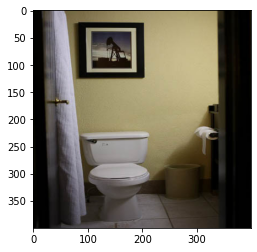

In [5]:
#plotting one image
import matplotlib.pyplot as plt
img_file = os.path.join(train_color_directory, os.listdir(train_color_directory)[0] )
img = plt.imread(img_file)
plt.imshow(img)

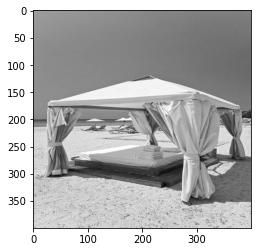

In [6]:
#plotting one image
img_file = os.path.join(train_bw_directory, os.listdir(train_bw_directory)[0] )
img = plt.imread(img_file)
plt.imshow(img)

### Converting all the color image to LAB

In [7]:
lab_dir_test = 'LAB_test'
lab_dir_train = 'LAB_train'
image_feature_dir = 'img_feature'
if not os.path.exists(lab_dir_test):
    os.mkdir(lab_dir_test)
if not os.path.exists(lab_dir_train):
    os.mkdir(lab_dir_train)
if not os.path.exists(image_feature_dir):
    os.mkdir(image_feature_dir)

In [8]:
import cv2
img = cv2.imread(img_file)
img_bw = cv2.imread(img_file, 0)
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
l,a,b = cv2.split(img_lab)

In [9]:
from tqdm import tqdm
for img_file in tqdm(os.listdir(train_color_directory)):
    img_path = os.path.join(train_color_directory, img_file)
    img = cv2.imread(img_path)
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    outfile_path = os.path.join(lab_dir_train,img_file)
#     outfile_path = outfile_path.replace('.jpg', '.lab')
    cv2.imwrite(outfile_path, lab_img)

100%|██████████| 5010/5010 [02:16<00:00, 36.81it/s] 


In [10]:
for img_file in tqdm(os.listdir(test_color_directory)):
    img_path = os.path.join(test_color_directory, img_file)
    img = cv2.imread(img_path)
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    outfile_path = os.path.join(lab_dir_test,img_file)
#     outfile_path = outfile_path.replace('.jpg', '.lab')
    cv2.imwrite(outfile_path, lab_img)

100%|██████████| 739/739 [00:15<00:00, 48.62it/s] 


### Pre-processing

In [11]:
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2DTranspose, ReLU

In [13]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


In [12]:
# pre-processing image for faster speed during training
def preprocess_image(img_path, shape=(299,299), preprocess_fn=tf.keras.applications.inception_v3.preprocess_input):
    img = cv2.imread(img_path)
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    l,a, b = cv2.split(lab_img)
    l = cv2.cvtColor(l, cv2.COLOR_GRAY2BGR)
    l = tf.image.resize(l, shape)
    l = preprocess_fn(l)
    return l

In [14]:
# Feature Extractor For Image
input = base_model.input
output = base_model.layers[-1].output
feature_extractor = tf.keras.Model(input, output)

In [15]:
# Utility Function for converting image into features 
import numpy as np
def get_image_feature(img_path):
  img = preprocess_image(img_path)
  feature = feature_extractor(np.reshape(img, (-1,299,299,3)))
#   feature = np.reshape(feature, (64,2048))
  base_name  = os.path.basename(img_path).replace('.jpg', '.npy')
  new_path = os.path.join(image_feature_dir, base_name)
    
  return feature, new_path

In [16]:
for img_file in tqdm(os.listdir(train_color_directory)):
    img_path = os.path.join(train_color_directory,img_file )
    feature, new_path = get_image_feature(img_path)
    np.save(new_path, feature)

100%|██████████| 5010/5010 [09:11<00:00,  9.09it/s]


In [17]:
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [18]:
img_path = os.path.join(train_color_directory, os.listdir(train_color_directory)[0] )
print(img_path)
feature, new_path = get_image_feature(img_path)

/content/drive/MyDrive/Research/Image Colorization Dataset/train_color/image3762.jpg


In [19]:
feature.shape

TensorShape([1, 8, 8, 2048])

### Building the Model

In [21]:
import keras
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Dense, UpSampling2D, Dropout, Input, Flatten, Reshape, MaxPool2D
from keras.layers.advanced_activations import LeakyReLU, ELU, ReLU
from keras.layers.convolutional import Conv2D
from tensorflow.keras.optimizers import Adam

In [22]:
inputs = tf.keras.Input(shape=(8, 8, 2048))
x = Conv2DTranspose(filters=512,kernel_size=(3,3),strides=(2, 2))(inputs)
x = ReLU()(x)
x = Conv2DTranspose(filters=128,kernel_size=(3,3),strides=(2, 2))(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=64,kernel_size=(3,3),strides=(2, 2))(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(2, 2))(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=2,kernel_size=(3,3),strides=(2, 2))(x)
outputs = tf.keras.activations.tanh(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="colorier")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics =['accuracy'])
model.summary()  

Model: "colorier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 2048)]      0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 17, 17, 512)      9437696   
 nspose)                                                         
                                                                 
 re_lu (ReLU)                (None, 17, 17, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 35, 35, 128)      589952    
 ranspose)                                                       
                                                                 
 re_lu_1 (ReLU)              (None, 35, 35, 128)       0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 71, 71, 64)       737

In [23]:
file_names = [f.split('.')[0] for f in os.listdir('img_feature')[:1000]]
file_names[:10]

['image4825',
 'image2986',
 'image2165',
 'image4069',
 'image3935',
 'image0141',
 'image3169',
 'image2746',
 'image0981',
 'image0485']

In [24]:
tmp = np.load(os.path.join('img_feature', '.'.join(['image2300', 'npy'])))
tmp = tmp.reshape((8,8,2048))
tmp.shape

(8, 8, 2048)

In [25]:
X_train = []
for name in file_names:
    img = np.load(os.path.join('img_feature', '.'.join([name, 'npy'])))
    img =img.reshape((8,8,2048))
    X_train.append(img)
print(len(X_train))

1000


In [26]:
X_train[0].shape

(8, 8, 2048)

In [27]:
Y_train = []
for name in file_names:
    img_path = os.path.join(train_color_directory, '.'.join([name, 'jpg']))
    img = cv2.imread(img_path)
    img = cv2.resize(img, (287,287), interpolation=cv2.INTER_AREA)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    ab = img_lab[:,:,1:]
    Y_train.append(ab/255) # normalize the output image
len(Y_train)

1000

In [28]:
# Custom Data Generator
class MyDataGenerator(tf.keras.utils.Sequence):

  def __init__(self, X, y, batch_size=32, shuffle=True):
    
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.X = X
    self.y = y 

    self.on_epoch_end()



  def on_epoch_end(self):
    self.indices = np.arange(len(self.X))
    if self.shuffle:
      np.random.shuffle(self.indices)
      
  def __len__(self):
    return int(np.floor(len(self.X)/self.batch_size))


  def __iter__(self):
    for item in ( self.__getitem__(i) for i in range(len(self))):
      yield item

  def __getitem__(self, index):
    idx = self.indices[ index * self.batch_size : (index +1) * self.batch_size ]
    # ids = [ self.image_ID[idx] for idx in indexes]
    X, y = self._generate_data(idx)
    return (X, y)

  def _generate_data(self, idx):

    x_shape = self.X[idx[0]].shape
    X = np.empty(shape=[self.batch_size, *x_shape])
    y_shape = self.y[idx[0]].shape
    y = np.empty(shape=[self.batch_size, *y_shape])

    for i, id in enumerate(idx):
      X[i] = self.X[id]
      y[i] = self.y[id]

    return X, y

datagen = MyDataGenerator(X_train, Y_train, batch_size=2)

In [29]:
epochs=30
history = model.fit(datagen, epochs=epochs)

Epoch 1/30
500/500 [==============================] - 10s 15ms/step - loss: 0.0701 - accuracy: 0.5352
Epoch 2/30
500/500 [==============================] - 7s 15ms/step - loss: 0.0391 - accuracy: 0.5627
Epoch 3/30
500/500 [==============================] - 7s 14ms/step - loss: 0.0373 - accuracy: 0.5834
Epoch 4/30
500/500 [==============================] - 7s 15ms/step - loss: 0.0369 - accuracy: 0.6059
Epoch 5/30
500/500 [==============================] - 7s 14ms/step - loss: 0.0353 - accuracy: 0.6265
Epoch 6/30
500/500 [==============================] - 7s 14ms/step - loss: 0.0337 - accuracy: 0.6400
Epoch 7/30
500/500 [==============================] - 7s 14ms/step - loss: 0.0327 - accuracy: 0.6506
Epoch 8/30
500/500 [==============================] - 7s 14ms/step - loss: 0.0316 - accuracy: 0.6633
Epoch 9/30
500/500 [==============================] - 7s 14ms/step - loss: 0.0298 - accuracy: 0.6721
Epoch 10/30
500/500 [==============================] - 7s 14ms/step - loss: 0.0288 - accur

In [30]:
history.history

{'accuracy': [0.535203218460083,
  0.5626978278160095,
  0.5834029912948608,
  0.6059340834617615,
  0.6264911890029907,
  0.6399554014205933,
  0.6505580544471741,
  0.6632714867591858,
  0.672076940536499,
  0.6775330901145935,
  0.6905814409255981,
  0.6961817741394043,
  0.7063846588134766,
  0.7118983268737793,
  0.7173652052879333,
  0.7211705446243286,
  0.7293736934661865,
  0.7362475395202637,
  0.7439722418785095,
  0.7448462247848511,
  0.7501102089881897,
  0.7510718107223511,
  0.7590110301971436,
  0.7632694244384766,
  0.7659733891487122,
  0.7656496167182922,
  0.7715294361114502,
  0.7726554274559021,
  0.7773295044898987,
  0.7737478613853455],
 'loss': [0.07014451920986176,
  0.039143066853284836,
  0.037344496697187424,
  0.03694184869527817,
  0.035336002707481384,
  0.0336906760931015,
  0.03274776041507721,
  0.031575847417116165,
  0.029795991256833076,
  0.02880345843732357,
  0.027723493054509163,
  0.026661507785320282,
  0.026176555082201958,
  0.02528796717

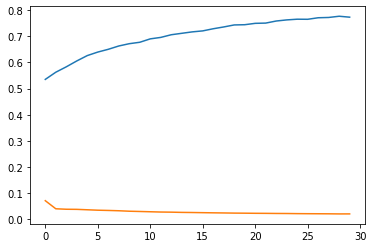

In [31]:
# first passs plotting
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')

In [32]:
f = os.listdir('img_feature')[900]
f_path_np = os.path.join('img_feature', f) 
f_path_img_color = os.path.join(train_color_directory, f.replace('.npy', '.jpg'))
f_path_img_bw = os.path.join(train_bw_directory, f.replace('.npy', '.jpg'))

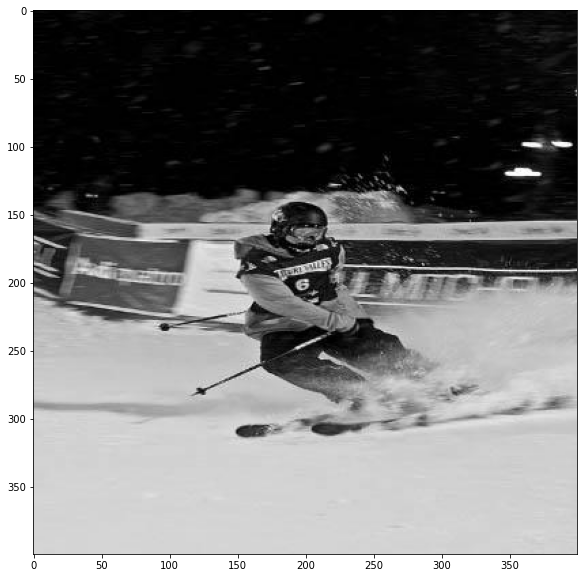

In [33]:
figure = plt.figure(figsize=(10,10))
plt.imshow(plt.imread(f_path_img_bw))

In [34]:
img_feature = np.load(f_path_np)
# img_feature.shape
y_hat = model.predict(img_feature)
# y_hat.shape

input_img = cv2.imread(f_path_img_bw, 0)
input_img = cv2.resize(input_img, (287,287))
input_img = input_img/255
# input_img.shape

final_output = np.zeros(shape=[287,287,3])
final_output[:,:,0] = input_img
final_output[:,:,1:] = y_hat[0]

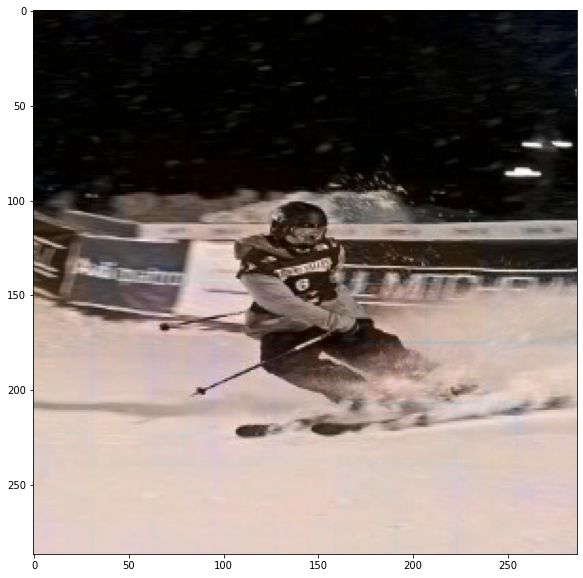

In [35]:
final_output_rbg = cv2.cvtColor((final_output * 255).astype(np.uint8), cv2.COLOR_LAB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(final_output_rbg)

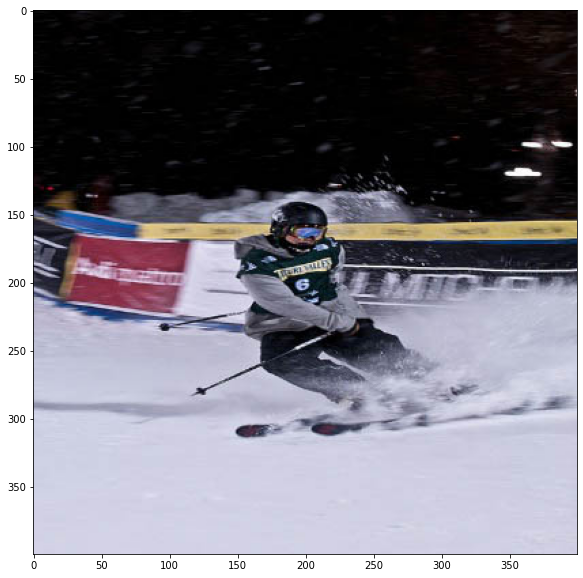

In [36]:
figure = plt.figure(figsize=(10,10))
plt.imshow(plt.imread(f_path_img_color))